# Combine Time Series and Downsample

In [23]:
import pandas as pd
import os
import csv
import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

We have these 804 distinct segments of sensor data.

In [2]:
metadata = pd.read_csv('metadata.csv')
metadata

,segment,waterbody,station,sensor_serial_number,latitude (degrees_north),longitude (degrees_east),deployment_start_date (UTC),deployment_end_date (UTC),depth (m)
0,Annapolis_Annapolis Basin_Lobster Ledge_208203...,Annapolis Basin,Lobster Ledge,20820380,44.678200,-65.683290,2020-06-11T00:00:00Z,2020-11-22T00:00:00Z,2.0
1,Annapolis_Annapolis Basin_Lobster Ledge_670381...,Annapolis Basin,Lobster Ledge,670381,44.678200,-65.683290,2020-06-11T00:00:00Z,2020-11-22T00:00:00Z,4.0
2,Annapolis_Annapolis Basin_Cornwallis_670367_44...,Annapolis Basin,Cornwallis,670367,44.669390,-65.644790,2020-06-11T00:00:00Z,2020-11-22T00:00:00Z,1.0
3,Annapolis_Annapolis Basin_Cornwallis_670380_44...,Annapolis Basin,Cornwallis,670380,44.669420,-65.644770,2020-11-22T00:00:00Z,2021-06-16T00:00:00Z,1.0
4,Annapolis_Annapolis Basin_Cornwallis_547089_44...,Annapolis Basin,Cornwallis,547089,44.669420,-65.644770,2020-11-22T00:00:00Z,2021-06-16T00:00:00Z,2.0
...,...,...,...,...,...,...,...,...,...
799,Yarmouth_Lobster Bay_Lobster Bay_548559_43.679...,Lobster Bay,Lobster Bay,548559,43.679035,-65.897960,2023-08-02T00:00:00Z,2024-08-07T00:00:00Z,5.0
800,Yarmouth_Lamonts Cove_Short Beach_548563_43.93...,Lamonts Cove,Short Beach,548563,43.930927,-66.167984,2023-08-03T00:00:00Z,2024-08-07T00:00:00Z,15.0
801,Yarmouth_Careys Cove_Yarmouth Bar_548586_43.83...,Careys Cove,Yarmouth Bar,548586,43.831528,-66.173210,2023-08-03T00:00:00Z,2024-08-07T00:00:00Z,15.0
802,Yarmouth_Lobster Bay_Ram Island_548597_43.6822...,Lobster Bay,Ram Island,548597,43.682230,-65.836205,2023-08-02T00:00:00Z,2024-08-07T00:00:00Z,8.0


Let's group these observation segments into more limited number of study sites where the waterbody, station, and depth are the same even if the sensor itself is replaced.

In [3]:
depths_list = [2.0, 5.0, 10.0, 15.0, 20.0]
study_sites = metadata[metadata['depth (m)'].isin(depths_list)][['waterbody', 'station', 'depth (m)']].drop_duplicates()
study_sites.reset_index(drop=True, inplace=True)

In [4]:
study_sites

,waterbody,station,depth (m)
0,Annapolis Basin,Lobster Ledge,2.0
1,Annapolis Basin,Cornwallis,2.0
2,Grahams Cove,Captains Pond,2.0
3,St. Georges Bay,St. Georges Bay S,15.0
4,Antigonish Harbour,1442,2.0
...,...,...,...
188,Careys Cove,Yarmouth Bar,10.0
189,Careys Cove,Yarmouth Bar,2.0
190,Lamonts Cove,Short Beach,2.0
191,Lamonts Cove,Short Beach,15.0


For any of these study sites we can consider all of the observational segements at that station and depth.

,segment,waterbody,station,sensor_serial_number,latitude (degrees_north),longitude (degrees_east),deployment_start_date (UTC),deployment_end_date (UTC),depth (m)
400,Halifax_St. Margarets Bay_Shut-In Island_67037...,St. Margarets Bay,Shut-In Island,670371,44.557550,-63.954140,2019-12-01T00:00:00Z,2020-11-08T00:00:00Z,5.0
408,Halifax_St. Margarets Bay_Shut-In Island_20834...,St. Margarets Bay,Shut-In Island,20834030,44.557533,-63.954110,2020-11-08T00:00:00Z,2021-05-21T00:00:00Z,5.0
419,Halifax_St. Margarets Bay_Shut-In Island_20834...,St. Margarets Bay,Shut-In Island,20834024,44.557640,-63.953907,2021-05-21T00:00:00Z,2021-11-26T00:00:00Z,5.0
425,Halifax_St. Margarets Bay_Shut-In Island_20834...,St. Margarets Bay,Shut-In Island,20834033,44.557484,-63.954050,2021-11-26T00:00:00Z,2022-05-12T00:00:00Z,5.0
426,Halifax_St. Margarets Bay_Shut-In Island_20834...,St. Margarets Bay,Shut-In Island,20834024,44.557484,-63.954050,2021-11-26T00:00:00Z,2022-05-12T00:00:00Z,5.0
428,Halifax_St. Margarets Bay_Shut-In Island_20834...,St. Margarets Bay,Shut-In Island,20834033,44.557560,-63.953926,2022-05-12T00:00:00Z,2022-11-03T00:00:00Z,5.0
439,Halifax_St. Margarets Bay_Shut-In Island_21429...,St. Margarets Bay,Shut-In Island,21429532,44.557434,-63.954094,2023-05-15T00:00:00Z,2023-11-10T00:00:00Z,5.0


Text(0, 0.5, 'temperature (degrees_Celsius)')

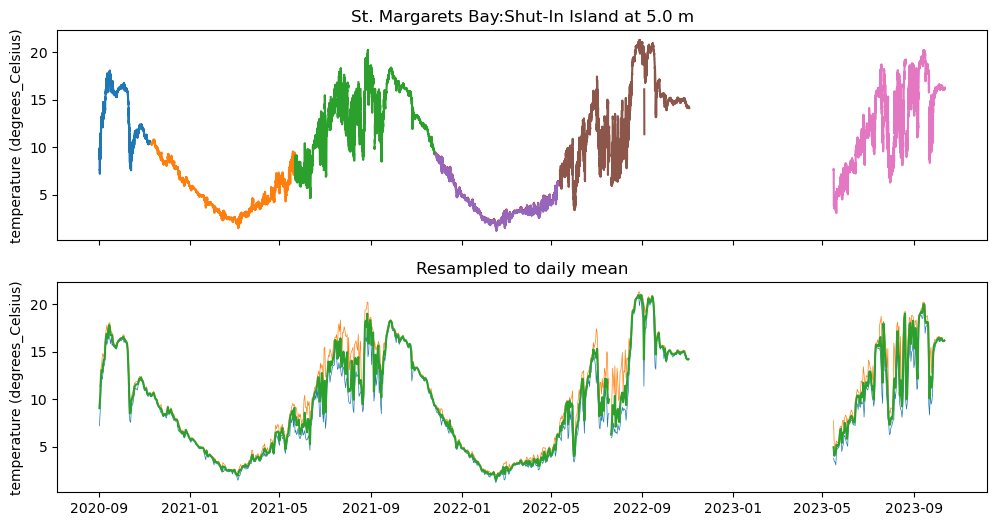

In [20]:
study_site = study_sites.iloc[83]

subset = metadata[ (metadata['waterbody'] == study_site['waterbody']) &  (metadata['station'] == study_site['station']) & (metadata['depth (m)'] == study_site['depth (m)'])]
display(subset)

fig, ax = plt.subplots(2,1, figsize=(12,6),sharex=True)

variable = 'temperature (degrees_Celsius)'
qc_flag = 'qc_flag_temperature'

series_segments = []
for index, row in subset.iterrows():

    csvfile = f"segments/{row['segment']}.csv"
       
    series = pd.read_csv(csvfile, index_col='time (UTC)', parse_dates=True)
    series.sort_index(inplace=True)

    # blank out observations that do not pass QC
    series[series[qc_flag] != 'Pass'] = np.nan
    series = series.drop(columns=[qc_flag])
    
    ax[0].plot(series.index, series[variable])
    
    ax[0].set_ylabel(variable)
    ax[0].set_title(f'{study_site.waterbody}:{study_site.station} at {study_site['depth (m)']} m')

    if series.count()[variable] > 0:
        series_segments.append(series)

series_df = pd.concat(series_segments)
series_df.sort_index(inplace=True)
daily_series_df = series_df.resample('D').max()

ax[1].set_title('Resampled to daily mean')
daily_series_df = series_df.resample('D').min()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='min', linewidth=0.5)
daily_series_df = series_df.resample('D').max()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='max', linewidth=0.5)
daily_series_df = series_df.resample('D').mean()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='mean')

ax[1].set_ylabel(variable)

At the time scale of four years, daily means are sufficient to see the cycle. The plot above shows the daily minimum and daily maximum.


In [26]:
start_date = "2020-09-01"
end_date = "2024-08-31"

daily_time_index = pd.date_range(start=start_date, end=end_date, freq='D')

data = pd.DataFrame(index=daily_time_index)

for study_site_id in tqdm(study_sites.index):

    study_site = study_sites.iloc[study_site_id]
    #print(f'[{study_site_id}] {study_site.waterbody}:{study_site.station} at {study_site['depth (m)']} m')
    
    subset = metadata[ (metadata['waterbody'] == study_site['waterbody']) &  (metadata['station'] == study_site['station']) & (metadata['depth (m)'] == study_site['depth (m)'])].copy()
    
    series_segments = []
    for segment_id in subset.index:

        csvfile = f"segments/{row['segment']}.csv"
        series = pd.read_csv(csvfile, index_col='time (UTC)', parse_dates=True)
        
        series.sort_index(inplace=True)

        # blank out observations that do not pass QC
        series[series[qc_flag] != 'Pass'] = np.nan
        series = series.drop(columns=[qc_flag])
       
        if series.count()[variable] > 0:
            series_segments.append(series)

    if len(series_segments) > 0:
        series_df = pd.concat(series_segments)
        series_df.sort_index(inplace=True)

        daily_series_df = series_df.resample('D').mean()
        
        data[study_site_id] = daily_series_df
    else:
        data[study_site_id] = np.nan
        
    

  0%|          | 0/193 [00:00<?, ?it/s]

/tmp/ipykernel_1662/1344318171.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[study_site_id] = daily_series_df
/tmp/ipykernel_1662/1344318171.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[study_site_id] = daily_series_df
/tmp/ipykernel_1662/1344318171.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `

In [29]:
df

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
2020-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


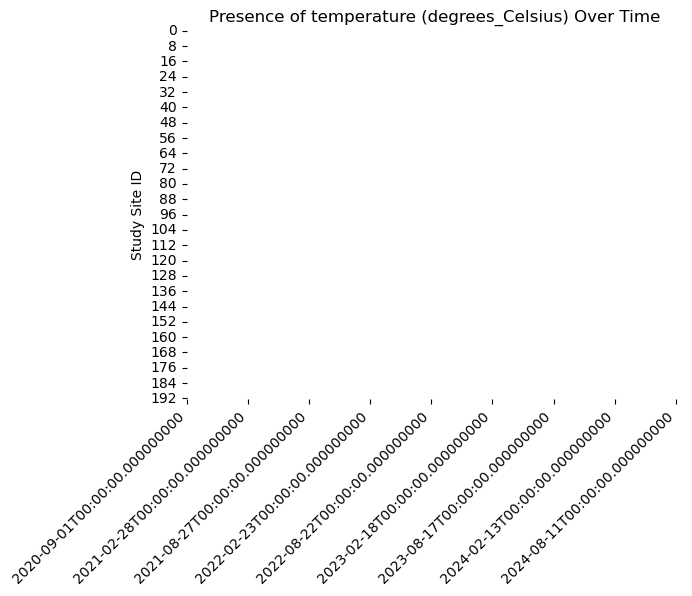

In [28]:
non_missing_data = ~df.isna()

import seaborn as sns
from matplotlib.dates import DateFormatter

plt.figure()
sns.heatmap(non_missing_data.T, xticklabels= 180, cmap=['white', 'black'], cbar=False)

plt.ylabel('Study Site ID')
plt.title(f'Presence of {variable} Over Time')

# Rotating the time axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.show()

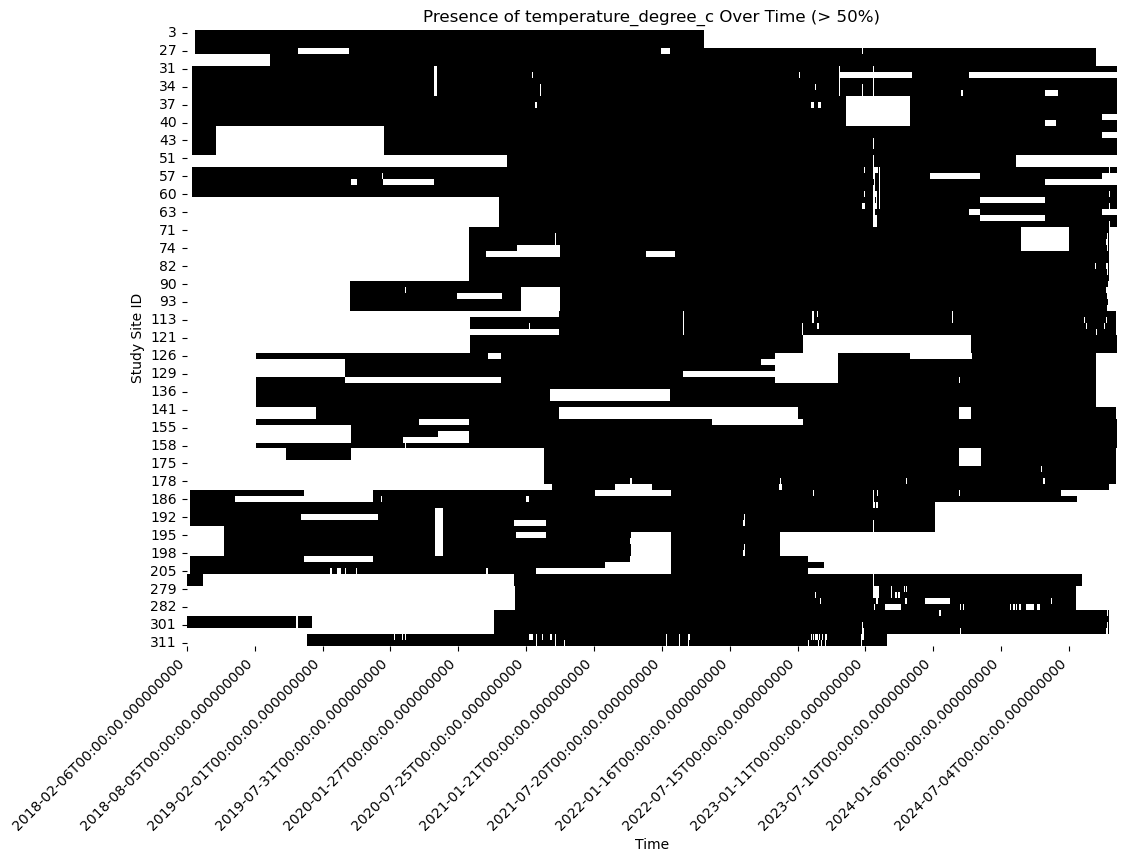

In [159]:
# Calculate the percentage of non-missing data for each study site
non_missing_percentage = df.notna().mean() * 100

# Filter study sites with at least 50% non-missing data
selected_sites = non_missing_percentage[non_missing_percentage >= 50].index
df_selected = df[selected_sites]

# Creating a boolean DataFrame where True indicates non-missing data
non_missing_data = ~df_selected.isna()

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(non_missing_data.T, xticklabels= 180, cmap=['white', 'black'], cbar=False)

# Formatting the time axis labels
date_format = DateFormatter('%Y-%m-%d %H:%M')
#plt.gca().xaxis.set_major_formatter(date_format)

plt.xlabel('Time')
plt.ylabel('Study Site ID')
plt.title(f'Presence of {variable} Over Time (> 50%)')

# Rotating the time axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()


In [163]:
selected_sites

Index([  3,   4,   5,  27,  28,  29,  31,  32,  33,  34,
       ...
       279, 280, 281, 282, 299, 300, 301, 302, 310, 311],
      dtype='int64', length=103)

,Unnamed: 0,waterbody,station,latitude,longitude,deployment_range,sensor_type,sensor_serial_number,sensor_depth_at_low_tide_m
1594,1594,Liverpool Bay,Mersey Point,44.026097,-64.665763,2022-Aug-10 to 2023-Aug-24,vr2ar,547093,15.0
1598,1598,Liverpool Bay,Mersey Point,44.026110,-64.665740,2020-Jun-25 to 2021-Aug-13,vr2ar,547112,15.0
1602,1602,Liverpool Bay,Mersey Point,44.026114,-64.665773,2023-Aug-24 to 2024-Jul-22,vr2ar,548555,15.0
1606,1606,Liverpool Bay,Mersey Point,44.026146,-64.665750,2021-Aug-13 to 2022-Aug-10,vr2ar,548044,15.0


Text(0, 0.5, 'temperature_degree_c')

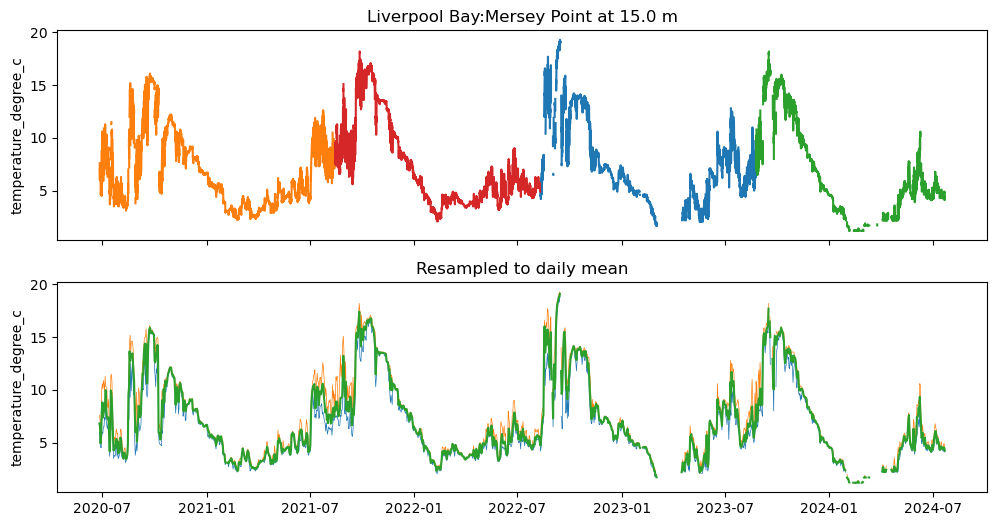

In [202]:
variable = 'temperature_degree_c'
#variable = 'dissolved_oxygen_percent_saturation'
qcflag = 'qc_flag_' + variable

study_site = study_sites.iloc[282]

subset = metadata[ (metadata['waterbody'] == study_site.waterbody) &  (metadata['station'] == study_site.station) & (metadata['sensor_depth_at_low_tide_m'] == study_site.sensor_depth_at_low_tide_m)]
display(subset)

fig, ax = plt.subplots(2,1, figsize=(12,6),sharex=True)

series_segments = []
for segment_id in subset.index:
     
    series_filename = os.path.join(variable, f'{segment_id}_{variable}.csv')
   
    series = pd.read_csv(series_filename, index_col='timestamp_utc', parse_dates=True, date_format="%m/%d/%Y %I:%M:%S %p")
    series.sort_index(inplace=True)

    # blank out observations that do not pass QC
    series[series[qcflag] != 'Pass'] = np.nan
    series = series.drop(columns=[qcflag])
    
    ax[0].plot(series.index, series[variable])
    
    ax[0].set_ylabel(variable)
    ax[0].set_title(f'{study_site.waterbody}:{study_site.station} at {study_site.sensor_depth_at_low_tide_m} m')


    if series.count()[variable] > 0:
        series_segments.append(series)

series_df = pd.concat(series_segments)
series_df.sort_index(inplace=True)
daily_series_df = series_df.resample('D').max()

ax[1].set_title('Resampled to daily mean')
daily_series_df = series_df.resample('D').min()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='min', linewidth=0.5)
daily_series_df = series_df.resample('D').max()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='max', linewidth=0.5)
daily_series_df = series_df.resample('D').mean()
ax[1].plot(daily_series_df.index, daily_series_df[variable], label='mean')

ax[1].set_ylabel(variable)



In [230]:
X

,3,4,5,27,28,29,31,32,33,34,...,279,280,281,282,299,300,301,302,310,311
2018-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.133417,0.156708,NaN,NaN,NaN
2018-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.254875,0.262917,NaN,NaN,NaN
2018-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.433542,0.455417,NaN,NaN,NaN
2018-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.399000,0.426667,NaN,NaN,NaN
2018-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.282542,0.313708,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-03,NaN,NaN,NaN,NaN,NaN,NaN,10.627708,NaN,10.239000,9.762271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-04,NaN,NaN,NaN,NaN,NaN,NaN,10.126417,NaN,9.979990,9.971750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-05,NaN,NaN,NaN,NaN,NaN,NaN,10.216333,NaN,10.114219,10.068219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-06,NaN,NaN,NaN,NaN,NaN,NaN,10.556427,NaN,10.400823,10.293156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Define $X = (X_1, ..., X_p)$ a data set of $n \times p$ dimensions, corresponding to $p$ study sites with $n$ recorded daily measurments.

In [215]:
X = df_selected

In [218]:
p = len(X.columns)
p

103

In [220]:
n = len(X)
n

2467

<Axes: >

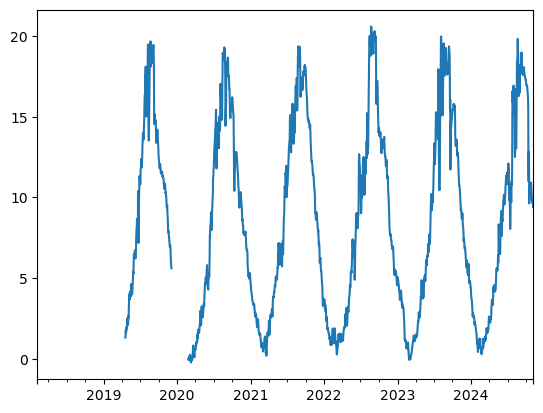

In [216]:
s = 67
X.iloc[:,s].plot()

$i_{miss} (s)$ is the set of days where site $s$ presents missing values.

In [221]:
Y_obs = X

In [224]:
missing_data = X.isna()

In [227]:
X[~missing_data]

,3,4,5,27,28,29,31,32,33,34,...,279,280,281,282,299,300,301,302,310,311
2018-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.133417,0.156708,NaN,NaN,NaN
2018-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.254875,0.262917,NaN,NaN,NaN
2018-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.433542,0.455417,NaN,NaN,NaN
2018-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.399000,0.426667,NaN,NaN,NaN
2018-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.282542,0.313708,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-03,NaN,NaN,NaN,NaN,NaN,NaN,10.627708,NaN,10.239000,9.762271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-04,NaN,NaN,NaN,NaN,NaN,NaN,10.126417,NaN,9.979990,9.971750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-05,NaN,NaN,NaN,NaN,NaN,NaN,10.216333,NaN,10.114219,10.068219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-06,NaN,NaN,NaN,NaN,NaN,NaN,10.556427,NaN,10.400823,10.293156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
